In [203]:
import os
import scipy.io
from scipy import signal
import statistics as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score,cross_validate,cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [204]:
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [205]:
data_dir = ["Dataset/DB1/s1/S1_A1_E3.mat"]#, "Dataset/DB1/s2/S2_A1_E3.mat", "Dataset/DB1/s3/S3_A1_E3.mat", "Dataset/DB1/s4/S4_A1_E3.mat", "Dataset/DB1/s4/S4_A1_E3.mat"]

mat_data = [scipy.io.loadmat(pac) for pac in data_dir]

In [206]:
emg = [mat['emg'] for mat in mat_data]
stimulus = [mat['stimulus'] for mat in mat_data]

In [207]:
labels_E3 = [
    (0,"Rest",""),
    (1,"Large diameter grasp",""),
    (2,"Small diameter grasp (power grip)", ""),
    (3,"Fixed hook grasp",""),
    (4,"Index finger extension grasp",""),
    (5,"Medium wrap","X"),
    (6,"Ring grasp",""),
    (7,"Prismatic four fingers grasp",""),
    (8,"Stick grasp",""),
    (9,"Writing tripod grasp","X"),
    (10,"Power sphere grasp",""),
    (11,"Three finger sphere grasp",""),
    (12,"Precision sphere grasp",""),
    (13,"Tripod grasp",""),
    (14,"Prismatic pinch grasp",""),
    (15,"Tip pinch grasp",""),
    (16,"Quadpod grasp",""),
    (17,"Lateral grasp",""),
    (18,"Parallel extension grasp",""),
    (19,"Extension type grasp",""),
    (20,"Power disk grasp",""),
    (21,"Open a bottle with a tripod grasp","X"),
    (22,"Turn a screw (grasp the screwdriver with a stick grasp",""),
    (23,"Cut something (grasp the knife with an index finger extension grasp)","X")
]

In [208]:
col_names = ['Electrode 1', 'Electrode 2', 'Electrode 3', 'Electrode 4', 'Electrode 5', 'Electrode 6', 'Electrode 7', 'Electrode 8', 'Electrode 9', 'Electrode 10']
list_df = [pd.DataFrame(pac, columns=col_names) for pac in emg]

for i in range(len(list_df)):
    list_df[i]['Stimulus'] = stimulus[i]

In [209]:
filtered_df = [df[df['Stimulus'].isin([5,9,21,23])] for df in list_df]

In [210]:
# Definir frequência de amostragem do sinal (assumindo que é igual para todos os eletrodos)
fs = 100
window_size = 400  # em ms
overlap = 0.5  # 50% de overlap

window_samples = int(window_size * fs / 1000)
overlap_samples = int(window_samples * overlap)

In [211]:
features = []

In [212]:
for df in filtered_df:
    window_starts = np.arange(0, len(df) - window_samples, overlap_samples)
    windows = [df.iloc[i:i+window_samples] for i in window_starts]
    rms_amplitude = np.sqrt(np.mean(np.square(windows), axis=1))

    for i in range(len(rms_amplitude)):
        rms_amplitude[i][-1] = st.mode(windows[i]['Stimulus'])

    features.append(rms_amplitude)

In [213]:
concatenated_features = np.concatenate((features), axis=0)

In [214]:
col_names = ['Electrode 1', 'Electrode 2', 'Electrode 3', 'Electrode 4', 'Electrode 5', 'Electrode 6', 'Electrode 7', 'Electrode 8', 'Electrode 9', 'Electrode 10', 'Stimulus']
df = pd.DataFrame(concatenated_features, columns=col_names)
df['Stimulus'] = df['Stimulus'].astype(int)

In [215]:
df

,Electrode 1,Electrode 2,Electrode 3,Electrode 4,Electrode 5,Electrode 6,Electrode 7,Electrode 8,Electrode 9,Electrode 10,Stimulus
0,0.016036,0.002400,0.002670,0.002400,0.002400,0.002400,0.055214,0.052972,0.002400,0.050420,5
1,0.003483,0.002400,0.002583,0.002400,0.002400,0.002400,0.053895,0.044746,0.002400,0.045700,5
2,0.004315,0.002400,0.002493,0.002493,0.005294,0.002400,0.062730,0.053966,0.002400,0.057906,5
3,0.004367,0.002400,0.002493,0.002493,0.005337,0.002493,0.100942,0.080847,0.002400,0.062823,5
4,0.004101,0.002400,0.002583,0.002400,0.008772,0.004316,0.110435,0.090771,0.002400,0.060103,5
...,...,...,...,...,...,...,...,...,...,...,...
1028,0.362202,0.204407,0.057575,0.003974,0.019645,0.018237,0.450491,0.943293,0.141459,0.018807,23
1029,0.221138,0.085065,0.020341,0.003638,0.033963,0.015021,0.416260,0.863568,0.139435,0.015305,23
1030,0.115502,0.005662,0.002493,0.002400,0.029752,0.023624,0.504847,0.663428,0.143221,0.012344,23
1031,0.101433,0.002400,0.002884,0.002400,0.011100,0.022552,0.393013,0.207873,0.138139,0.233678,23


In [216]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

from sklearn.preprocessing import StandardScaler
X =  StandardScaler().fit_transform(X)

In [217]:
# normalizar os dados para ter média 0 e desvio padrão 1
X = (X - X.mean(axis=0)) / X.std(axis=0)
pca = PCA()
pca.fit(X)

variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(variance_ratio)

print(variance_ratio)
print(cumulative_variance_ratio)

n_components = np.argmax(cumulative_variance_ratio >= 0.70) + 1
print(n_components)

X_pca = pca.transform(X)[:, :n_components]

# imprimir a proporção da variância explicada pelos componentes principais
#print(pca.explained_variance_ratio_)

# obter os pesos dos eletrodos nos componentes principais
#eletrodos_pca = pca.components_

#print(eletrodos_pca)

[0.54007218 0.13206906 0.08105712 0.07798301 0.06302039 0.0359286
 0.02908666 0.02029977 0.01164147 0.00884174]
[0.54007218 0.67214124 0.75319835 0.83118136 0.89420175 0.93013036
 0.95921702 0.97951679 0.99115826 1.        ]
3


In [218]:
#best_elet = [np.argmax(best_feat)+1 for best_feat in eletrodos_pca]
#best_elet.sort()
#best_elet

In [219]:
#X = df[[f'Electrode {i}' for i in best_elet]].values
#X = df.iloc[:, :-1].values
X = X_pca
y = df.iloc[:, -1].values

In [220]:
#from sklearn.preprocessing import StandardScaler
#X =  StandardScaler().fit_transform(X)

In [221]:
X.shape

(1033, 3)

In [222]:
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [223]:
print("Mapping of Label Encoded Classes", label_encoder_name_mapping, sep="\n")
print("Label Encoded Target Variable", encoded_y, sep="\n")

Mapping of Label Encoded Classes
{5: 0, 9: 1, 21: 2, 23: 3}
Label Encoded Target Variable
[0 0 0 ... 3 3 3]


In [224]:
all_models = [
    xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.01),
    RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42),
    svm.SVC(kernel='linear', random_state=42),
    svm.SVC(kernel='rbf', random_state=42),
    KNeighborsClassifier(n_neighbors=4),
    LinearDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizes=(21,), activation='logistic', max_iter=3000)
]

In [225]:
all_models_names = ["XGBoost", "Random\nForest", "SVM\n(Linear)", "SVM\n(RBF)", "KNN", "LDA", "MLP"]
results_acc = []
results_std = []
results_prec = []
results_rec = []
results_f1 = []
results_cm = []

In [226]:
for model, name in zip(all_models, all_models_names):
    scores = cross_val_score(model, X, encoded_y, cv=4)
    y_pred = cross_val_predict(model, X, encoded_y, cv=4)

    accuracy = accuracy_score(encoded_y, y_pred)
    precision = precision_score(encoded_y, y_pred, average='macro')
    recall = recall_score(encoded_y, y_pred, average='macro')
    f1 = f1_score(encoded_y, y_pred, average='macro')

    results_acc.append(np.mean(scores))
    results_std.append(np.std(scores))
    results_prec.append(precision)
    results_rec.append(recall)
    results_f1.append(f1)
    results_cm.append( confusion_matrix(y, y_pred)[4:, :4] )
    
    print('\t' + name)
    print('Cross-validation scores:', scores)
    print(f"Cross-validation mean score: {np.mean(scores):.2f} (+/- {np.std(scores):.2f})")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print()

	XGBoost
Cross-validation scores: [0.67181467 0.79069767 0.70542636 0.71317829]
Cross-validation mean score: 0.72 (+/- 0.04)
Accuracy: 0.7202323330106486
Precision: 0.7216255630769848
Recall: 0.7201904442176815
F1 score: 0.7206202889798188

	Random
Forest
Cross-validation scores: [0.67953668 0.78294574 0.75193798 0.69767442]
Cross-validation mean score: 0.73 (+/- 0.04)
Accuracy: 0.7279767666989352
Precision: 0.7312281150285104
Recall: 0.7280135562723111
F1 score: 0.7292444705440042

	SVM
(Linear)
Cross-validation scores: [0.5019305  0.6744186  0.62403101 0.62403101]
Cross-validation mean score: 0.61 (+/- 0.06)
Accuracy: 0.6060019361084221
Precision: 0.60572402013676
Recall: 0.6055738548442828
F1 score: 0.5966910751342624

	SVM
(RBF)
Cross-validation scores: [0.66409266 0.74418605 0.69379845 0.68992248]
Cross-validation mean score: 0.70 (+/- 0.03)
Accuracy: 0.6979670861568248
Precision: 0.7389603307516805
Recall: 0.6974769853660904
F1 score: 0.6974768793358267

	KNN
Cross-validation sco

In [227]:
# Combine the lists into a list of lists
list_of_lists = [results_acc, results_std, results_prec, results_rec, results_f1]

# Save the list of lists to a text file
with open('400msPCA.txt', 'w') as f:
    for sublist in list_of_lists:
        f.write('%s\n' % sublist)

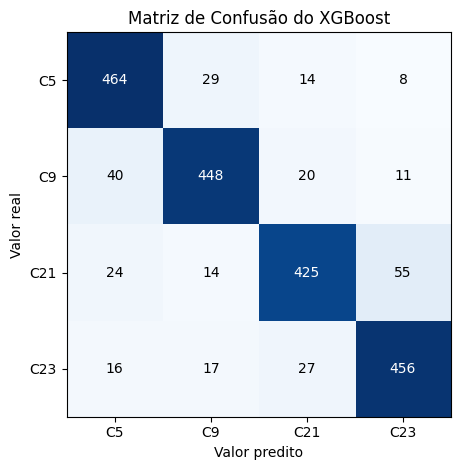

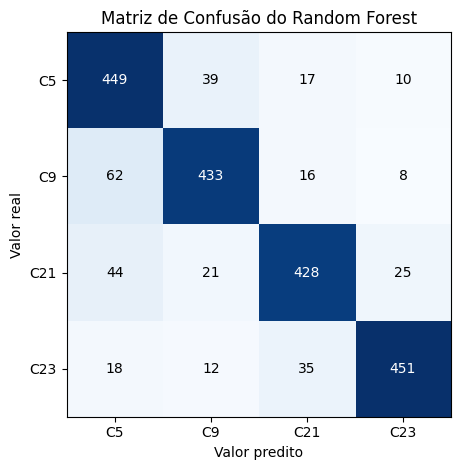

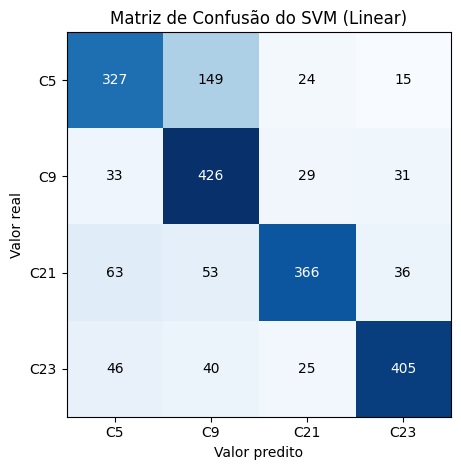

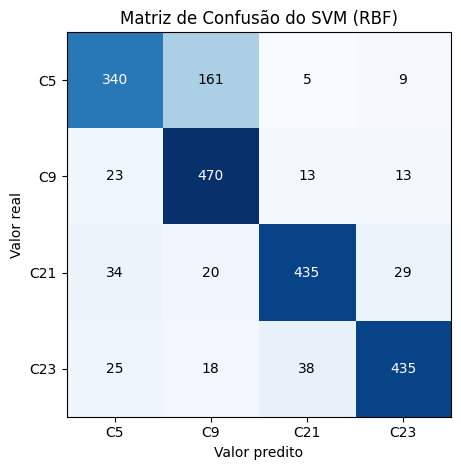

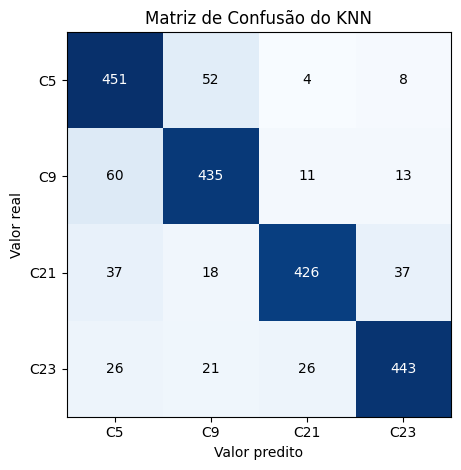

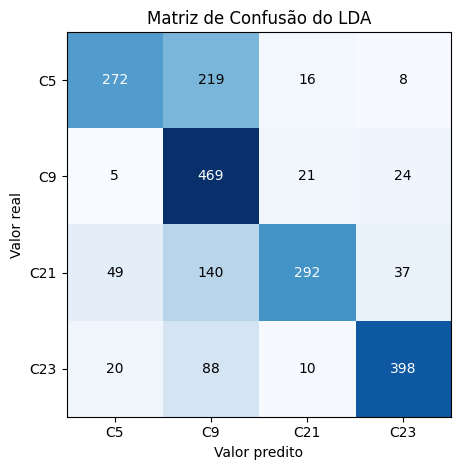

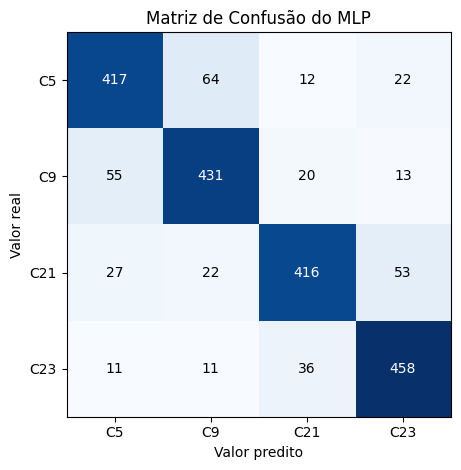

In [99]:
models_names = ["XGBoost", "Random Forest", "SVM (Linear)", "SVM (RBF)", "KNN", "LDA", "MLP"]

# Plot the confusion matrix as a heatmap
for cm, name in zip(results_cm, models_names):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=["C5", "C9", "C21", "C23"],
        yticklabels=["C5", "C9", "C21", "C23"],
        title=f"Matriz de Confusão do {name}",
        ylabel='Valor real',
        xlabel='Valor predito')

    plt.setp(ax.get_xticklabels(), rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > cm.max()/2 else "black"
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

    fig.tight_layout()
    plt.savefig(f"CM_{name}.png")
    plt.show()


In [228]:
# Read the list of lists from the text file
res200ms = []
res100ms = []
res400ms = []

with open('100ms.txt', 'r') as f:
    lines = f.readlines()
    res100ms = [eval(line) for line in lines]
with open('200ms.txt', 'r') as f:
    lines = f.readlines()
    res200ms = [eval(line) for line in lines]
with open('400ms.txt', 'r') as f:
    lines = f.readlines()
    res400ms = [eval(line) for line in lines]

accuracy = np.vstack((res400ms[0], res200ms[0], res100ms[0])).T
std = np.vstack((res400ms[1], res200ms[1], res100ms[1])).T

In [231]:
for line in res200ms:
    for num in line:
        print(f"{num:.2f}", end=" & ")
    print()

0.87 & 0.85 & 0.74 & 0.81 & 0.85 & 0.69 & 0.84 & 
0.07 & 0.06 & 0.06 & 0.05 & 0.05 & 0.03 & 0.07 & 
0.87 & 0.85 & 0.75 & 0.82 & 0.85 & 0.75 & 0.83 & 
0.87 & 0.85 & 0.74 & 0.81 & 0.85 & 0.69 & 0.83 & 
0.87 & 0.85 & 0.74 & 0.81 & 0.85 & 0.69 & 0.83 & 


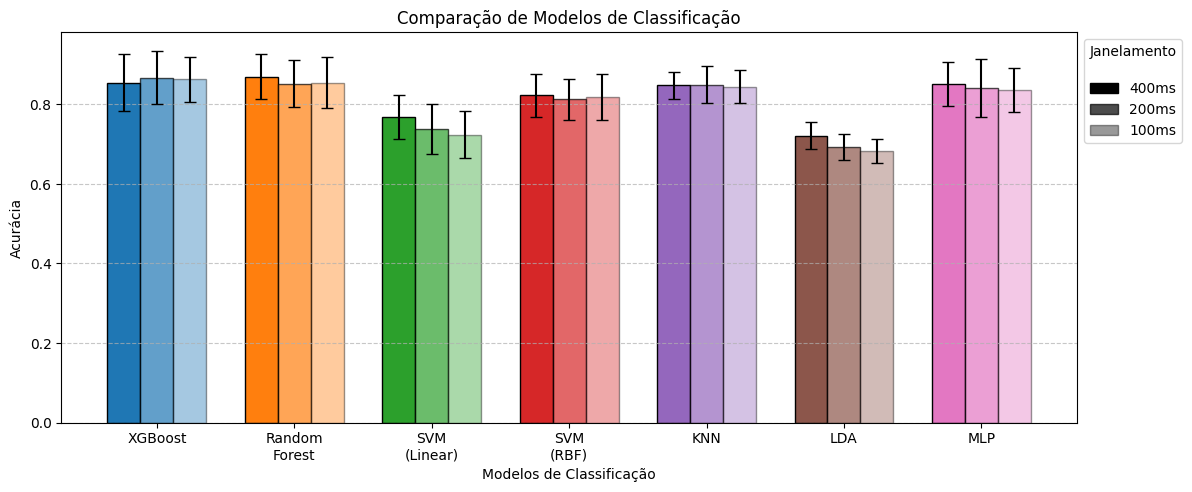

In [232]:
models = all_models_names

# Data for the 7 models and 3 features
features = ['400ms', '200ms', '100ms']
values = accuracy

# Define the colors for each model
model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "#9467bd", '#8c564b', "#e377c2"]

# Define the transparency levels for each feature group
alphas = [1.0, 0.7, 0.4]

# Set the width of each bar
bar_width = 0.24

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12,5))
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# Iterate over the 3 features and create a group of 7 bars for each feature
for i, feature in enumerate(features):
    # Define the x positions for each bar group
    x_pos = np.arange(len(models)) + (i * bar_width)

    # Iterate over the 7 models and plot the bars for the current feature group
    for j, model in enumerate(models):
        ax.bar(x_pos[j], values[j, i], edgecolor='black', yerr=std[j,i], width=bar_width, color=model_colors[j], alpha=alphas[i], capsize=4, label=model if i == 0 else "")

# Add labels, legend, and title
ax.set_xlabel('Modelos de Classificação')
ax.set_ylabel('Acurácia')
ax.set_title('Comparação de Modelos de Classificação')
ax.set_xticks(np.arange(len(models)) + bar_width)
ax.set_xticklabels(models)


patches = [plt.Rectangle((0,0), 1, 1, color="#000000", alpha=alphas[i]) for i in range(len(features))]
labels = features

# Add the legend manually
ax.legend(patches, labels, loc='upper left', bbox_to_anchor=(1,1), title="Janelamento\n")
fig.tight_layout(pad=1.0)
plt.savefig("accuracy.png")

plt.show()


In [233]:
# Read the list of lists from the text file
res200ms = []
res100ms = []
res400ms = []

with open('100msPCA.txt', 'r') as f:
    lines = f.readlines()
    res100ms = [eval(line) for line in lines]
with open('200msPCA.txt', 'r') as f:
    lines = f.readlines()
    res200ms = [eval(line) for line in lines]
with open('400msPCA.txt', 'r') as f:
    lines = f.readlines()
    res400ms = [eval(line) for line in lines]

accuracy = np.vstack((res400ms[0], res200ms[0], res100ms[0])).T
std = np.vstack((res400ms[1], res200ms[1], res100ms[1])).T

In [234]:
for line in res200ms:
    for num in line:
        print(f"{num:.2f}", end=" & ")
    print()

0.71 & 0.70 & 0.59 & 0.68 & 0.71 & 0.54 & 0.73 & 
0.05 & 0.04 & 0.06 & 0.03 & 0.03 & 0.05 & 0.04 & 
0.71 & 0.71 & 0.60 & 0.72 & 0.72 & 0.54 & 0.74 & 
0.71 & 0.70 & 0.59 & 0.67 & 0.71 & 0.54 & 0.73 & 
0.71 & 0.70 & 0.58 & 0.67 & 0.71 & 0.53 & 0.73 & 


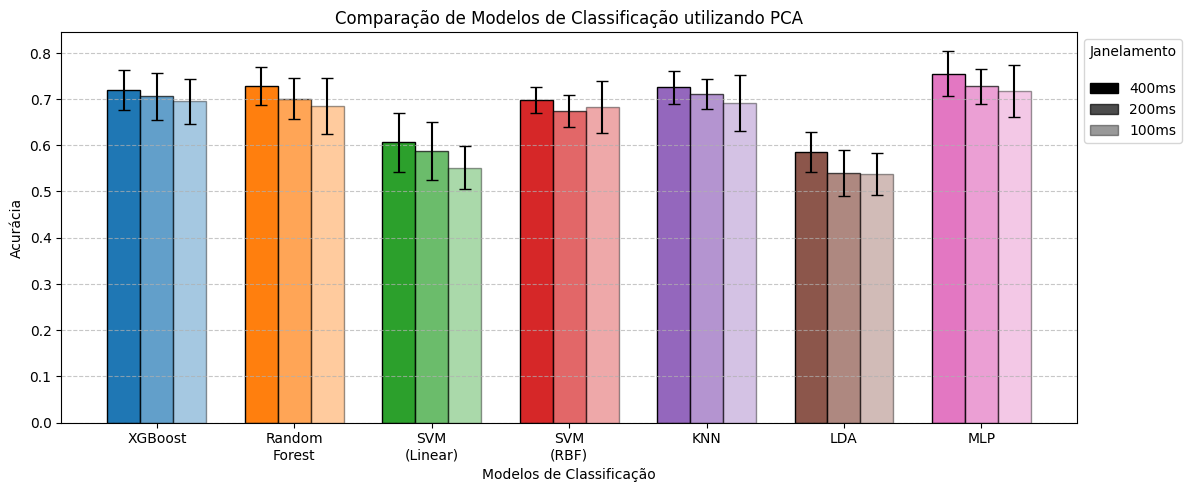

In [235]:
models = all_models_names

# Data for the 7 models and 3 features
features = ['400ms', '200ms', '100ms']
values = accuracy

# Define the colors for each model
model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "#9467bd", '#8c564b', "#e377c2"]

# Define the transparency levels for each feature group
alphas = [1.0, 0.7, 0.4]

# Set the width of each bar
bar_width = 0.24

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12,5))
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
# Iterate over the 3 features and create a group of 7 bars for each feature
for i, feature in enumerate(features):
    # Define the x positions for each bar group
    x_pos = np.arange(len(models)) + (i * bar_width)

    # Iterate over the 7 models and plot the bars for the current feature group
    for j, model in enumerate(models):
        ax.bar(x_pos[j], values[j, i], edgecolor='black', yerr=std[j,i], width=bar_width, color=model_colors[j], alpha=alphas[i], capsize=4, label=model if i == 0 else "")

# Add labels, legend, and title
ax.set_xlabel('Modelos de Classificação')
ax.set_ylabel('Acurácia')
ax.set_title('Comparação de Modelos de Classificação utilizando PCA')
ax.set_xticks(np.arange(len(models)) + bar_width)
ax.set_xticklabels(models)


patches = [plt.Rectangle((0,0), 1, 1, color="#000000", alpha=alphas[i]) for i in range(len(features))]
labels = features

# Add the legend manually
ax.legend(patches, labels, loc='upper left', bbox_to_anchor=(1,1), title="Janelamento\n")
fig.tight_layout(pad=1.0)
plt.savefig("accuracyPCA.png")

plt.show()


[0 1 2 3 4 5 6]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (0,).

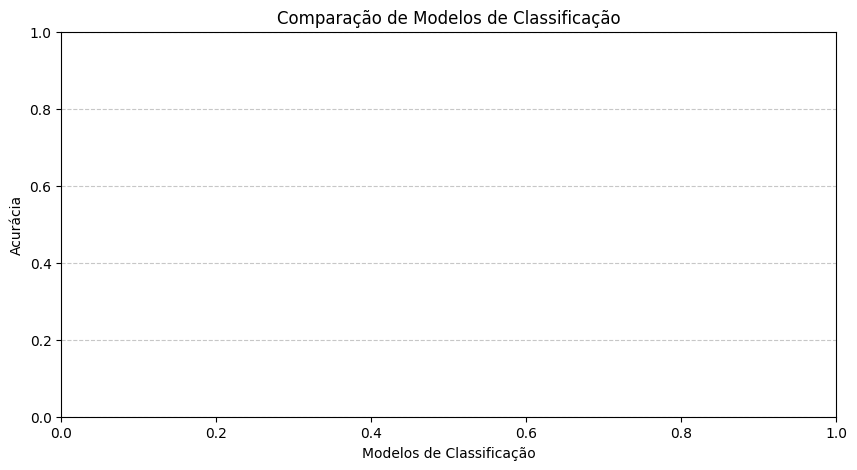

In [25]:
# accuracy and std values for each model
accuracy = results_acc
std = results_std
models = all_models_names

# create figure and axis objects
fig, ax = plt.subplots(figsize=(10,5))

ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

# set x-axis label
ax.set_xlabel('Modelos de Classificação')

# set y-axis label
ax.set_ylabel('Acurácia')

# set title
ax.set_title('Comparação de Modelos de Classificação')

# set axis limits
ax.set_ylim([0, 1])


# set positions and width of bars
pos = np.arange(len(models))

print(pos)
width = 0.6

# plot bars with accuracy and std values
bars = ax.bar(pos, accuracy, width, yerr=std, align='center', alpha=1, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "#9467bd", '#8c564b', "#e377c2"], capsize=10)

# set the zorder of the bars to a higher value than the grid
for bar in bars:
    bar.set_zorder(1)

# set tick positions and labels
ax.set_xticks(pos)
ax.set_xticklabels(models)

# display the plot
#plt.savefig("accuracy.png")
plt.show()